# DAA Experiment Harness (Template)
**Tujuan**: kerangka eksperimen untuk membandingkan *Algoritma A* vs *Algoritma B* pada instance unik per kelompok.
1. Isi `algo_A` dan `algo_B`.
2. Sesuaikan `generate_instances` atau loader data.
3. Atur `Ns`, `repeats`, `seed`.


In [1]:
import os, time, random, statistics
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

Path('results').mkdir(exist_ok=True)

random.seed(42)
np.random.seed(42)

## Data Aquisition

In [2]:
##LOAD DATA

import pandas as pd

df = pd.read_csv(
    r"E:\PROJEK DAA\DAA_Kelompok4_KelasA_IntSched\data\normalized_fix_2.csv"
)

df.head(10)

,Hari,Mata Kuliah,Semester,SKS,Dosen,Ruang,Kelas,Kapasitas Kelas,start,finish,duration,jumlah_mahasiswa,profit_density
0,Senin,Kalkulus I,1,3,SUPRIYADI WIBOWO,R001,A,25,09:20:00,10:10:00,50.0,16,0.06
1,Senin,Kalkulus I,1,3,SUPRIYADI WIBOWO,R001,A,25,10:15:00,11:05:00,50.0,13,0.06
2,Senin,Kalkulus I,1,3,SUPRIYADI WIBOWO,R001,A,25,11:10:00,12:00:00,50.0,22,0.06
3,Senin,Pengolahan Citra Digital,5,3,HERI PRASETYO,R001,B,25,13:00:00,13:50:00,50.0,24,0.06
4,Senin,Pengolahan Citra Digital,5,3,HERI PRASETYO,R001,B,25,13:55:00,14:45:00,50.0,20,0.06
5,Senin,Pengolahan Citra Digital,5,3,HERI PRASETYO,R001,B,25,15:30:00,16:20:00,50.0,17,0.06
6,Senin,Data Mining,5,3,WIRANTO,R001,E,25,16:25:00,17:15:00,50.0,22,0.06
7,Senin,Data Mining,5,3,WIRANTO,R001,E,25,18:10:00,19:00:00,50.0,14,0.06
8,Senin,Data Mining,5,3,WIRANTO,R001,E,25,22:15:00,23:05:00,50.0,16,0.06
9,Senin,Bahasa Indonesia,1,2,KUNDHARU SADDHONO,R002,C,40,13:00:00,13:50:00,50.0,34,0.04


In [3]:
df.columns

Index(['Hari', 'Mata Kuliah', 'Semester', 'SKS', 'Dosen', 'Ruang', 'Kelas',
       'Kapasitas Kelas', 'start', 'finish', 'duration', 'jumlah_mahasiswa',
       'profit_density'],
      dtype='object')

## Implementasi Algoritma A (Greedy EFT)

In [ ]:
def run_algo_eft(data):
    start_time = time.perf_counter()                 # O(1)

    sorted_data = data.sort_values(                  # O(n log n)
        by=["finish_abs", "start_abs", "id"],
        kind="mergesort"
    )

    schedule = []                                    # O(1)
    last_finish = -1                                 # O(1)

    for _, row in sorted_data.iterrows():            # O(n)
        if row["start_abs"] >= last_finish:          # O(1)
            schedule.append(row)                     # O(1)
            last_finish = row["finish_abs"]          # O(1)

    runtime_ms = (time.perf_counter() - start_time) * 1000  # O(1)
    return schedule, runtime_ms                      # O(1)

## Implementasi Algoritma B (Greedy Profit Density)

In [ ]:
def run_algo_density(data):
    start_time = time.perf_counter()                     # O(1)

    sorted_data = data.sort_values(                      # O(n log n)
        by=["profit_density", "finish_abs", "id"],
        ascending=[False, True, True],                   # O(1)
        kind="mergesort"
    )

    schedule = []                                        # O(1)
    occupied = []                                        # O(1)

    for _, row in sorted_data.iterrows():                # O(n)
        s, f = row["start_abs"], row["finish_abs"]       # O(1)
        conflict = False                                 # O(1)

        for os, of in occupied:                          # O(k) ⊆ O(n)
            if s < of and f > os:                         # O(1)
                conflict = True                          # O(1)
                break                                    # O(1)

        if not conflict:                                 # O(1)
            schedule.append(row)                         # O(1) amortized
            occupied.append((s, f))                      # O(1) amortized

    runtime_ms = (time.perf_counter() - start_time) * 1000  # O(1)
    return schedule, runtime_ms                          # O(1)

## Pembangkit/Loader Instance (SESUAIKAN)

In [ ]:
import pandas as pd                                  # O(1)

# =========================================================
# 1. LOAD DATASET
# =========================================================

def load_dataset(path):
    df = pd.read_csv(path)                           # O(n)

    # Pastikan kolom waktu string
    df['start'] = df['start'].astype(str)            # O(n)
    df['finish'] = df['finish'].astype(str)          # O(n)

    # Mapping hari ke angka
    day_map = {                                      # O(1)
        'Senin': 0,
        'Selasa': 1,
        'Rabu': 2,
        'Kamis': 3,
        'Jumat': 4,
        'Sabtu': 5,
        'Minggu': 6
    }

    def get_minutes(day, time_str):                  # O(1)
        if day not in day_map:                       # O(1)
            return -1                                # O(1)
        h, m, s = map(int, time_str.split(':'))      # O(1)
        return day_map[day] * 24 * 60 + h * 60 + m   # O(1)

    # Konversi ke waktu absolut
    df['start_abs'] = df.apply(                      # O(n)
        lambda x: get_minutes(x['Hari'], x['start']), axis=1
    )
    df['finish_abs'] = df.apply(                     # O(n)
        lambda x: get_minutes(x['Hari'], x['finish']), axis=1
    )

    # Tambahkan ID unik
    df['id'] = df.index                              # O(n)

    return df                                        # O(1)

In [ ]:
# =========================================================
# 2. GENERATE INSTANCES
# =========================================================

def generate_instances(df, min_size=2):
    """
    1 instance = kelas-kelas pada hari & ruang yang sama
    """

    instances = []                                   # O(1)

    grouped = df.groupby(['Hari', 'Ruang'])          # O(n)

    for (hari, ruang), group in grouped:             # O(g), g = jumlah grup
        if len(group) >= min_size:                   # O(1)
            instances.append({                       # O(1)
                'hari': hari,                        # O(1)
                'ruang': ruang,                      # O(1)
                'data': group.sort_values(           # O(k log k)
                    by=['start_abs', 'finish_abs']
                ).reset_index(drop=True)             # O(k)
            })

    return instances                                 # O(1)

In [ ]:
path = r"E:\PROJEK DAA\DAA_Kelompok4_KelasA_IntSched\data\normalized_fix_2.csv"  # O(1)

df = load_dataset(path)              # O(N)
instances = generate_instances(df)   # O(N log N)

print("Jumlah instance:", len(instances))      # O(1)

print("\nContoh instance pertama:")             # O(1)
print("Hari :", instances[0]['hari'])           # O(1)
print("Ruang:", instances[0]['ruang'])          # O(1)
print(instances[0]['data'].head())              # O(1)


Jumlah instance: 50

Contoh instance pertama:
Hari : Jumat
Ruang: R001
    Hari             Mata Kuliah  Semester  SKS           Dosen Ruang Kelas  \
0  Jumat  Pendidikan Agama Islam         1    2  RELLY PRIHATIN  R001     A   
1  Jumat  Pendidikan Agama Islam         1    2  RELLY PRIHATIN  R001     A   

   Kapasitas Kelas     start    finish  duration  jumlah_mahasiswa  \
0               25  16:25:00  17:15:00      50.0                15   
1               25  18:10:00  19:00:00      50.0                22   

   profit_density  start_abs  finish_abs   id  
0            0.04       6745        6795  334  
1            0.04       6850        6900  335  


## Evaluator & Timing

In [ ]:
# =========================================================
# EVALUATOR SOLUSI
# =========================================================

def evaluate_schedule(schedule):
    """
    schedule: list of rows (hasil run_algo_*)
    """

    n_selected = len(schedule)                  # O(1)

    # Total profit (SKS)
    total_sks = sum(row['SKS'] for row in schedule)   # O(n)

    # Validitas (tidak konflik)
    is_valid = True
    for i in range(len(schedule)):              # O(n)
        for j in range(i + 1, len(schedule)):   # O(n)
            a = schedule[i]
            b = schedule[j]
            if not (
                a['finish_abs'] <= b['start_abs'] or
                b['finish_abs'] <= a['start_abs']
            ):
                is_valid = False
                break

    return {
        'n_selected': n_selected,   # O(1)
        'total_sks': total_sks,     # O(1)
        'is_valid': is_valid        # O(1)
    }


In [ ]:
import time

def run_with_timing_precise(algo_func, data):
    t0 = time.perf_counter()          # O(1)
    schedule, _ = algo_func(data)     # O(T_algo) → tergantung algoritma (EFT/Density)
    t1 = time.perf_counter()          # O(1)
    return schedule, (t1 - t0) * 1000 # O(1)


In [ ]:
## GAP EVALUATOR - EFT BASELINE
def compute_gap(optimal_profit, algo_profit):
    if optimal_profit == 0:          # O(1)
        return 0.0                   # O(1)
    return (optimal_profit - algo_profit) / optimal_profit  # O(1)


In [ ]:
inst = instances[0]        # O(1)
data_inst = inst['data']   # O(1)


In [ ]:
eft_schedule, eft_time = run_with_timing_precise(run_algo_eft, data_inst)  # O(n log n)
eft_eval = evaluate_schedule(eft_schedule)                                # O(k^2)

print("EFT Evaluation:", eft_eval)  # O(1)
print("Runtime (ms):", eft_time)    # O(1)

EFT Evaluation: {'n_selected': 2, 'total_sks': 4, 'is_valid': True}
Runtime (ms): 3.2622000003357243


In [ ]:
den_schedule, den_time = run_with_timing_precise(run_algo_density, data_inst)  # O(n^2)
den_eval = evaluate_schedule(den_schedule)                                    # O(k^2)

print("Density Evaluation:", den_eval)  # O(1)
print("Runtime (ms):", den_time)        # O(1)


Density Evaluation: {'n_selected': 2, 'total_sks': 4, 'is_valid': True}
Runtime (ms): 2.172200000131852


In [ ]:
gap = compute_gap(eft_eval['total_sks'], den_eval['total_sks'])  # O(1)
print("Gap:", gap)                                              # O(1)


Gap: 0.0


In [ ]:
import time

def run_with_timing(algo_func, data):
    """
    Jalankan algoritma + ukur runtime (ms)
    """
    t0 = time.perf_counter()              # O(1)
    schedule, _ = algo_func(data)         # O(T_algo) → tergantung algoritma (EFT: O(n log n), Density: O(n²))
    t1 = time.perf_counter()              # O(1)

    runtime_ms = (t1 - t0) * 1000         # O(1)
    return schedule, runtime_ms           # O(1)


## Eksekusi Eksperimen (atur parameter)

In [ ]:
import pandas as pd
import numpy as np
import time

# =========================================================
# 1. LOAD & PREPROCESS DATA
# =========================================================

df = pd.read_csv(
    r"E:\PROJEK DAA\DAA_Kelompok4_KelasA_IntSched\data\normalized_fix_2.csv"
)
df["profit_density"] = df["profit_density"].fillna(0)  # O(n)

day_map = {
    'Senin': 0,
    'Selasa': 1,
    'Rabu': 2,
    'Kamis': 3,
    'Jumat': 4,
    'Sabtu': 5,
    'Minggu': 6
}

def get_minutes(day, time_str):  # O(1)
    if day not in day_map:
        return -1
    h, m, s = map(int, time_str.split(':'))
    return day_map[day] * 24 * 60 + h * 60 + m

df["start_abs"] = df.apply(lambda x: get_minutes(x["Hari"], x["start"]), axis=1)   # O(n)
df["finish_abs"] = df.apply(lambda x: get_minutes(x["Hari"], x["finish"]), axis=1) # O(n)

df['id'] = df.index  # O(n)

# =========================================================
# 2. GREEDY ALGORITHMS
# =========================================================

def run_algo_eft(data):
    start_time = time.perf_counter()  # O(1)

    sorted_data = data.sort_values(
        by=["finish_abs", "start_abs", "id"], 
        kind="mergesort"
    )  # O(n log n)

    schedule = []       # O(1)
    last_finish = -1    # O(1)

    for _, row in sorted_data.iterrows():  # O(n)
        if row["start_abs"] >= last_finish:  # O(1)
            schedule.append(row)              # O(1)
            last_finish = row["finish_abs"]   # O(1)

    runtime_ms = (time.perf_counter() - start_time) * 1000  # O(1)
    return schedule, runtime_ms


def run_algo_density(data):
    start_time = time.perf_counter()  # O(1)

    sorted_data = data.sort_values(
        by=["profit_density", "finish_abs", "id"], 
        ascending=[False, True, True], 
        kind="mergesort"
    )  # O(n log n)

    schedule = []    # O(1)
    occupied = []    # O(1)

    for _, row in sorted_data.iterrows():  # O(n)
        s, f = row["start_abs"], row["finish_abs"]  # O(1)
        conflict = False                            # O(1)

        for os, of in occupied:  # O(k) ⊆ O(n)
            if s < of and f > os:  # O(1)
                conflict = True    # O(1)
                break              # O(1)

        if not conflict:           # O(1)
            schedule.append(row)   # O(1)
            occupied.append((s, f))# O(1)

    runtime_ms = (time.perf_counter() - start_time) * 1000  # O(1)
    return schedule, runtime_ms


# =========================================================
# 3. EXPERIMENT SETUP
# =========================================================

results = []  # O(1)
experiment_id = "Greedy_Scheduling_EFT_vs_Density"  # O(1)

sizes_to_test = [10, 20, 30, 40]  # O(1)
seeds_to_test = [0, 1]            # O(1)
r = 2                              # O(1)

# =========================================================
# 4. RUN EXPERIMENTS
# =========================================================

for sz in sizes_to_test:          # O(|N|)
    for seed in seeds_to_test:    # O(|S|)
        subset = df.sample(
            n=sz, 
            random_state=seed
        ).reset_index(drop=True)  # O(n)

        # -------- EFT --------
        eft_schedule, eft_time = run_algo_eft(subset)  # O(n log n)
        count_eft = len(eft_schedule)                  # O(1)
        sks_eft = sum(row["SKS"] for row in eft_schedule)  # O(n)

        results.append({  # O(1)
            "experiment_id": experiment_id,
            "n": sz,
            "seed": seed,
            "algorithm": "EFT",
            "scheduled_classes": count_eft,
            "total_sks": sks_eft,
            "runtime_ms": eft_time
        })

        # -------- Density --------
        den_schedule, den_time = run_algo_density(subset)  # O(n^2)
        count_den = len(den_schedule)                      # O(1)
        sks_den = sum(row["SKS"] for row in den_schedule)  # O(n)

        results.append({  # O(1)
            "experiment_id": experiment_id,
            "n": sz,
            "seed": seed,
            "algorithm": "Density",
            "scheduled_classes": count_den,
            "total_sks": sks_den,
            "runtime_ms": den_time
        })

# =========================================================
# 5. SUMMARY
# =========================================================

results_df = pd.DataFrame(results)  # O(n)

summary = results_df.pivot_table(
    index=["n", "seed"],
    columns="algorithm",
    values=["scheduled_classes", "total_sks", "runtime_ms"]
)  # O(n)

print(summary)  # O(1)


=== EKSPERIMEN GREEDY | n = 10 | seed = 0 ===

[Greedy EFT] Running...
[Greedy EFT] Hasil:
  - n : 10
  - seed    : 0
  - repeat    : 2
  - algorithm: EFT
  - Runtime (ms) : 2.3581
  - Interval (Kelas) : 8
  - Profit (SKS)   : 24
  - Selected IDs   : [60, 102, 134, 238, 230, 261, 297, 400]

[Greedy Density] Running...
[Greedy Density] Hasil:
  - n : 10
  - seed    : 0
  - repeat    : 2
  - algorithm: Density
  - Runtime (ms) : 2.5748
  - Interval (Kelas) : 8
  - Profit (SKS)   : 26
  - Selected IDs   : [102, 307, 60, 134, 238, 230, 303, 400]

=== EKSPERIMEN GREEDY | n = 10 | seed = 1 ===

[Greedy EFT] Running...
[Greedy EFT] Hasil:
  - n : 10
  - seed    : 1
  - repeat    : 2
  - algorithm: EFT
  - Runtime (ms) : 2.2563
  - Interval (Kelas) : 10
  - Profit (SKS)   : 28
  - Selected IDs   : [29, 62, 146, 92, 238, 172, 292, 296, 360, 374]

[Greedy Density] Running...
[Greedy Density] Hasil:
  - n : 10
  - seed    : 1
  - repeat    : 2
  - algorithm: Density
  - Runtime (ms) : 3.7243
  -

In [ ]:
print("\n==================== DETAIL SOLUSI EKSPERIMEN ====================")  # O(1)

for _, row in results_df.iterrows():  # O(m)
    print("\n--------------------------------------------------")  # O(1)
    print(f"[Experiment ID] : {row['experiment_id']}")   # O(1)
    print(f"Algorithm       : {row['algorithm']}")       # O(1)
    print(f"n (interval)    : {row['n']}")               # O(1)
    print(f"Seed            : {row['seed']}")            # O(1)
    print(f"Runtime (ms)    : {row['runtime_ms']:.4f}") # O(1)
    print(f"Jumlah kelas    : {row['scheduled_classes']}") # O(1)
    print(f"Total SKS       : {row['total_sks']}")       # O(1)

    # ============================================
    # REKONSTRUKSI DATA
    # ============================================

    subset = df.sample(
        n=int(row['n']),
        random_state=int(row['seed'])
    ).reset_index(drop=True)  # O(n)

    # ============================================
    # JALANKAN ULANG ALGORITMA
    # ============================================

    if row['algorithm'] == "EFT":        # O(1)
        schedule, _ = run_algo_eft(subset)  # O(n log n)
    elif row['algorithm'] == "Density":  # O(1)
        schedule, _ = run_algo_density(subset)  # O(n²)
    else:
        print("Algoritma tidak dikenal.")  # O(1)
        continue                           # O(1)

    print("\nDetail Kelas Terpilih:")      # O(1)
    print("--------------------------------------------------")  # O(1)

    for cls in schedule:  # O(k) ⊆ O(n)
        print(            # O(1)
            f"• {cls['Hari']:6} | "
            f"{cls['start']}–{cls['finish']} | "
            f"{cls['Mata Kuliah']} | "
            f"Kelas {cls['Kelas']} | "
            f"SKS {cls['SKS']} | "
            f"Dosen: {cls['Dosen']}"
        )


==================== DETAIL SOLUSI EKSPERIMEN ====================

--------------------------------------------------
[Experiment ID] : Greedy_Scheduling_EFT_vs_Density
Algorithm       : EFT
n (interval)    : 10
Seed            : 0
Runtime (ms)    : 2.3581
Jumlah kelas    : 8
Total SKS       : 24

Detail Kelas Terpilih:
--------------------------------------------------
• Senin  | 09:20:00–10:10:00 | Teori Game | Kelas B | SKS 3 | Dosen: NUGHTHOH ARFAWI KURDHI
• Selasa | 07:30:00–08:20:00 | Basis Data | Kelas B | SKS 4 | Dosen: BRILYAN HENDRASURYAWAN
• Selasa | 10:15:00–11:05:00 | Sistem Manajemen Basis Data | Kelas B | SKS 3 | Dosen: DEWI WISNU WARDANI
• Rabu   | 11:10:00–12:00:00 | Matematika Diskrit dan Teori Graph | Kelas A | SKS 3 | Dosen: ENDRA PRATAMA
• Rabu   | 15:30:00–16:20:00 | Basis Pengetahuan dan Penalaran | Kelas A | SKS 3 | Dosen: DEWI WISNU WARDANI
• Kamis  | 13:55:00–14:45:00 | Pendidikan Pancasila | Kelas B | SKS 2 | Dosen: IRWAN IFTADI
• Kamis  | 16:25:00–17:15:00

In [19]:
results_df.columns

Index(['experiment_id', 'n', 'seed', 'algorithm', 'scheduled_classes',
       'total_sks', 'runtime_ms'],
      dtype='object')

## Hardware Specification

In [ ]:
import platform
import psutil
import cpuinfo
import shutil
import subprocess

def get_local_hw_spec():                     # O(1)
    # OS & Python
    os_name = platform.system()              # O(1)
    os_version = platform.platform()         # O(1)
    python_version = platform.python_version()  # O(1)

    # CPU
    cpu_brand = cpuinfo.get_cpu_info().get("brand_raw", "Unknown")  # O(1)
    cpu_cores_physical = psutil.cpu_count(logical=False)            # O(1)
    cpu_cores_logical = psutil.cpu_count(logical=True)              # O(1)

    # RAM
    ram_total_gb = psutil.virtual_memory().total / (1024 ** 3)      # O(1)

    # GPU (optional, Windows & Linux)
    gpu_name = "Not detected"              # O(1)
    try:
        if os_name == "Windows":            # O(1)
            out = subprocess.check_output(  # O(1)
                "wmic path win32_VideoController get name",
                shell=True
            ).decode()                      # O(1)
            lines = [l.strip() for l in out.splitlines() if l.strip() and "Name" not in l]  # O(n)
            if lines:                       # O(1)
                gpu_name = ", ".join(lines)  # O(n)

        elif os_name == "Linux":             # O(1)
            out = subprocess.check_output(   # O(1)
                ["bash", "-lc", "lspci | grep -i vga"],
                stderr=subprocess.DEVNULL
            ).decode().strip()               # O(1)
            if out:                          # O(1)
                gpu_name = out               # O(1)

    except:
        pass                                 # O(1)

    return {                                 # O(1)
        "OS": os_version,
        "Python": python_version,
        "CPU": cpu_brand,
        "CPU Cores (Physical)": cpu_cores_physical,
        "CPU Cores (Logical)": cpu_cores_logical,
        "RAM Total (GB)": round(ram_total_gb, 2),
        "GPU": gpu_name
    }

# Jalankan
spec = get_local_hw_spec()                   # O(1)

print("=== HARDWARE SPEC (Local VS Code Runtime) ===")  # O(1)
for k, v in spec.items():                    # O(m)
    print(f"{k:>22}: {v}")                   # O(1)

=== HARDWARE SPEC (Local VS Code Runtime) ===
                    OS: Windows-11-10.0.26200-SP0
                Python: 3.13.1
                   CPU: AMD Ryzen 7 7435HS
  CPU Cores (Physical): 8
   CPU Cores (Logical): 16
        RAM Total (GB): 15.82
                   GPU: NVIDIA GeForce RTX 2050


## Measure Time and Memory Used

In [ ]:
import time
import tracemalloc

# =========================================================
# MEASURE TIME & MEMORY
# =========================================================

def run_with_time_and_memory(algo_func, data):   # O(T_algo + M_algo)
    """
    Menjalankan algoritma greedy + mengukur:
    - waktu eksekusi (ms)
    - peak memory usage (KB)
    """

    tracemalloc.start()                           # O(1)

    t0 = time.perf_counter()                      # O(1)

    schedule, _ = algo_func(data)                 # O(T_algo)

    t1 = time.perf_counter()                      # O(1)

    current, peak = tracemalloc.get_traced_memory()  # O(1)

    tracemalloc.stop()                            # O(1)

    runtime_ms = (t1 - t0) * 1000                 # O(1)
    memory_kb = peak / 1024                       # O(1)

    return schedule, runtime_ms, memory_kb        # O(1)

In [ ]:
inst = instances[0]          # O(1)
data_inst = inst['data']     # O(1)

In [ ]:
schedule_eft, time_eft, mem_eft = run_with_time_and_memory(  # O(n log n) time, O(n) space
    run_algo_eft, data_inst
)

eval_eft = evaluate_schedule(schedule_eft)                   # O(k²), k = jumlah kelas terpilih

print("[EFT]")                                                # O(1)
print("Runtime (ms):", time_eft)                               # O(1)
print("Memory (KB):", mem_eft)                                 # O(1)
print("Jumlah kelas:", eval_eft['n_selected'])                 # O(1)
print("Total SKS:", eval_eft['total_sks'])                     # O(1)

[EFT]
Runtime (ms): 15.28280000002269
Memory (KB): 15.65234375
Jumlah kelas: 2
Total SKS: 4


In [ ]:
schedule_den, time_den, mem_den = run_with_time_and_memory(  # O(n log n + n·k) time, O(n) space
    run_algo_density, data_inst
)

eval_den = evaluate_schedule(schedule_den)                   # O(k²), k = jumlah kelas terpilih

print("\n[Density]")                                         # O(1)
print("Runtime (ms):", time_den)                              # O(1)
print("Memory (KB):", mem_den)                                # O(1)
print("Jumlah kelas:", eval_den['n_selected'])                # O(1)
print("Total SKS:", eval_den['total_sks'])                    # O(1)


[Density]
Runtime (ms): 14.55660000010539
Memory (KB): 15.7060546875
Jumlah kelas: 2
Total SKS: 4


## Plot & Tabel

In [ ]:
# =========================================================
# TABEL: n vs Mean Runtime (DENGAN PEMENANG)
# =========================================================

mean_runtime_table = (                                   # O(m), m = jumlah baris results_df
    results_df
    .groupby(['n', 'algorithm'])['runtime_ms']           # O(m)
    .mean()                                              # O(m)
    .reset_index()                                       # O(m)
    .rename(columns={'runtime_ms': 'mean_runtime_ms'})   # O(1)
)

comparison_table = mean_runtime_table.pivot(             # O(m)
    index='n',
    columns='algorithm',
    values='mean_runtime_ms'
)

comparison_table['WINNER (Fastest)'] = (                 # O(n)
    comparison_table.idxmin(axis=1)
)

if 'EFT' in comparison_table.columns and 'Density' in comparison_table.columns:
    comparison_table['Diff (ms)'] = (                    # O(n)
        abs(comparison_table['EFT'] - comparison_table['Density'])
    )

print("\n===== PERBANDINGAN KECEPATAN (RUNTIME) =====")     # O(1)
print(comparison_table)                                  # O(n)


===== PERBANDINGAN KECEPATAN (RUNTIME) =====
algorithm  Density      EFT WINNER (Fastest)  Diff (ms)
n                                                      
10         3.14955  2.30720              EFT    0.84235
20         3.58625  3.19530              EFT    0.39095
30         3.61060  3.38385              EFT    0.22675
40         4.12725  4.38135          Density    0.25410


In [ ]:
import pandas as pd

# =========================================================
# TABEL: n vs Runtime (MEAN & SD)
# =========================================================

if 'results_df' in locals() and not results_df.empty:              # O(1)

    stats_table = (                                                 # O(m)
        results_df
        .groupby(['n', 'algorithm'])['runtime_ms']                  # O(m)
        .agg(['mean', 'std'])                                       # O(m)
        .reset_index()                                              # O(m)
    )

    comparison_table = stats_table.pivot(                           # O(m)
        index='n',
        columns='algorithm',
        values=['mean', 'std']
    )

    comparison_table.columns = [                                    # O(k)
        f"{algo}_{metric.upper()}" 
        for metric, algo in comparison_table.columns
    ]

    mean_cols = [c for c in comparison_table.columns if '_MEAN' in c]  # O(k)

    comparison_table['WINNER'] = (                                  # O(n)
        comparison_table[mean_cols]
        .idxmin(axis=1)
        .apply(lambda x: x.split('_')[0])
    )

    if 'EFT_MEAN' in comparison_table.columns and 'Density_MEAN' in comparison_table.columns:
        comparison_table['Diff Mean (ms)'] = (                      # O(n)
            abs(comparison_table['EFT_MEAN'] - comparison_table['Density_MEAN'])
        )

    final_cols = (                                                  # O(k log k)
        sorted([c for c in comparison_table.columns if 'WINNER' not in c and 'Diff' not in c])
        + ['Diff Mean (ms)', 'WINNER']
    )

    print("\n===== PERBANDINGAN KECEPATAN (MEAN & SD) =====")          # O(1)
    print(comparison_table[final_cols])                             # O(n)

else:
    print("DataFrame 'results_df' tidak ditemukan atau kosong.")     # O(1)



===== PERBANDINGAN KECEPATAN (MEAN & SD) =====
    Density_MEAN  Density_STD  EFT_MEAN   EFT_STD  Diff Mean (ms)   WINNER
n                                                                         
10       3.14955     0.812819   2.30720  0.071983         0.84235      EFT
20       3.58625     0.537048   3.19530  0.237022         0.39095      EFT
30       3.61060     0.014991   3.38385  0.188444         0.22675      EFT
40       4.12725     0.284610   4.38135  0.442012         0.25410  Density


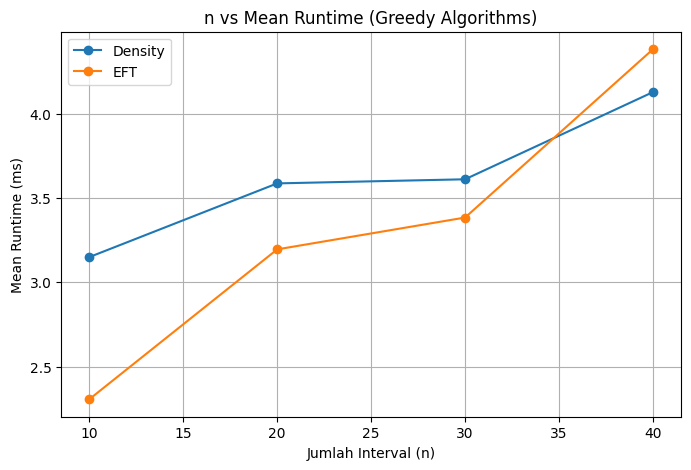

In [ ]:
import matplotlib.pyplot as plt                               # O(1)

# =========================================================
# LINE CHART: n vs Mean Runtime (Greedy)
# =========================================================

plt.figure(figsize=(8, 5))                                    # O(1)

for algo in mean_runtime_table['algorithm'].unique():         # O(a)
    subset = mean_runtime_table[
        mean_runtime_table['algorithm'] == algo               # O(m)
    ]

    plt.plot(
        subset['n'],                                          # O(n)
        subset['mean_runtime_ms'],                             # O(n)
        marker='o',
        label=algo
    )                                                         # O(n)

plt.xlabel('Jumlah Interval (n)')                              # O(1)
plt.ylabel('Mean Runtime (ms)')                                # O(1)
plt.title('n vs Mean Runtime (Greedy Algorithms)')             # O(1)
plt.legend()                                                   # O(a)
plt.grid(True)                                                 # O(1)

plt.show()                                                     # O(1)

C:\Users\Asus\AppData\Local\Temp\ipykernel_27388\3368475889.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


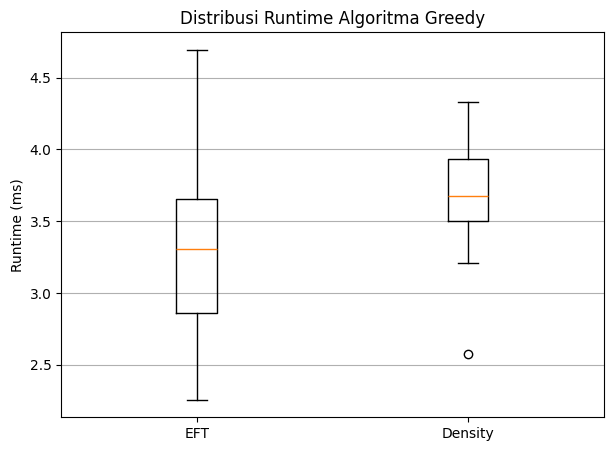

In [ ]:
import matplotlib.pyplot as plt                                   # O(1)

# =========================================================
# BOXPLOT: Runtime per Algoritma (tanpa n)
# =========================================================

plt.figure(figsize=(7, 5))                                        # O(1)

# Ambil data runtime per algoritma
data_to_plot = [
    results_df[results_df['algorithm'] == 'EFT']['runtime_ms'],   # O(m)
    results_df[results_df['algorithm'] == 'Density']['runtime_ms']# O(m)
]

plt.boxplot(
    data_to_plot,                                                 # O(m)
    labels=['EFT', 'Density'],                                    # O(1)
    showfliers=True
)

plt.ylabel('Runtime (ms)')                                        # O(1)
plt.title('Distribusi Runtime Algoritma Greedy')                  # O(1)

plt.grid(True, axis='y')                                         # O(1)
plt.show()                                                        # O(1)


In [ ]:
# =========================================================
# PIVOT: EFT vs Density
# =========================================================

pivot_df = results_df.pivot_table(          # O(m)
    index=['n', 'seed'],                    # O(m)
    columns='algorithm',                    # O(m)
    values='total_sks'                      # O(m)
).reset_index()                             # O(k)

print(pivot_df.head())                      # O(1)

algorithm   n  seed  Density   EFT
0          10     0     26.0  24.0
1          10     1     28.0  28.0
2          20     0     49.0  46.0
3          20     1     48.0  47.0
4          30     0     67.0  64.0


In [ ]:
# =========================================================
# HITUNG GAP (%)
# =========================================================

pivot_df['gap_percent'] = (                         # O(m)
    (pivot_df['EFT'] - pivot_df['Density'])          # O(m)
    / pivot_df['EFT']                                # O(m)
) * 100                                              # O(m)

print(pivot_df[['n', 'seed', 'gap_percent']])        # O(m)

algorithm   n  seed  gap_percent
0          10     0    -8.333333
1          10     1     0.000000
2          20     0    -6.521739
3          20     1    -2.127660
4          30     0    -4.687500
5          30     1    -1.666667
6          40     0    -6.578947
7          40     1    -1.250000


In [ ]:
# =========================================================
# TABEL: n vs Mean Gap (%)
# =========================================================

mean_gap_table = (                                   # O(m)
    pivot_df                                        # O(1)
    .groupby('n')['gap_percent']                    # O(m)
    .mean()                                         # O(m)
    .reset_index()                                  # O(m)
    .rename(columns={'gap_percent': 'mean_gap_percent'})  # O(m)
)

print("\n===== TABEL n vs MEAN GAP (%) =====")          # O(1)
print(mean_gap_table)                                # O(m)


===== TABEL n vs MEAN GAP (%) =====
    n  mean_gap_percent
0  10         -4.166667
1  20         -4.324699
2  30         -3.177083
3  40         -3.914474


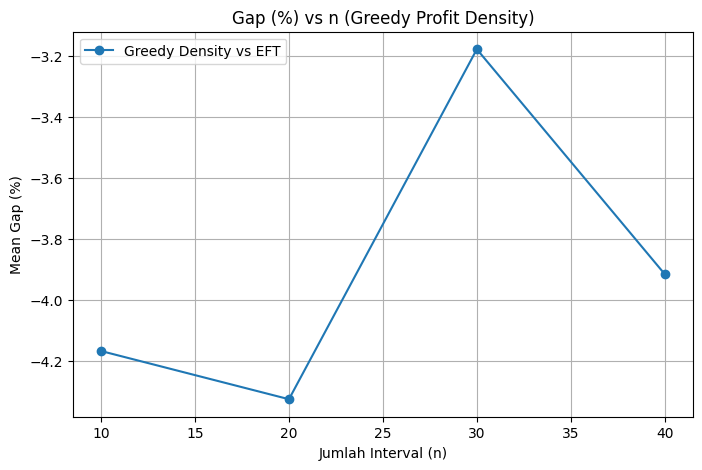

In [ ]:
import matplotlib.pyplot as plt                           # O(1)

# =========================================================
# LINE CHART: Gap (%) vs n (Greedy)
# =========================================================

plt.figure(figsize=(8, 5))                               # O(1)

plt.plot(                                                 # O(n)
    mean_gap_table['n'],                                 # O(n)
    mean_gap_table['mean_gap_percent'],                  # O(n)
    marker='o',                                          # O(1)
    label='Greedy Density vs EFT'                         # O(1)
)

plt.xlabel('Jumlah Interval (n)')                        # O(1)
plt.ylabel('Mean Gap (%)')                               # O(1)
plt.title('Gap (%) vs n (Greedy Profit Density)')        # O(1)
plt.legend()                                             # O(1)
plt.grid(True)                                           # O(1)

plt.show()                                               # O(1)

In [ ]:
# =========================================================
# TABEL: n vs Mean Intervals Processed
# =========================================================

mean_intervals_table = (                                  # O(N)
    results_df                                            # O(1)
    .groupby(['n', 'algorithm'])['scheduled_classes']     # O(N)
    .mean()                                               # O(N)
    .reset_index()                                        # O(N)
    .rename(columns={                                    # O(1)
        'scheduled_classes': 'mean_intervals_processed'
    })
)

print("\n===== TABEL n vs MEAN INTERVALS PROCESSED =====")   # O(1)
print(mean_intervals_table)                               # O(N)


===== TABEL n vs MEAN INTERVALS PROCESSED =====
    n algorithm  mean_intervals_processed
0  10   Density                       9.0
1  10       EFT                       9.0
2  20   Density                      16.5
3  20       EFT                      16.5
4  30   Density                      21.5
5  30       EFT                      21.5
6  40   Density                      27.5
7  40       EFT                      27.5


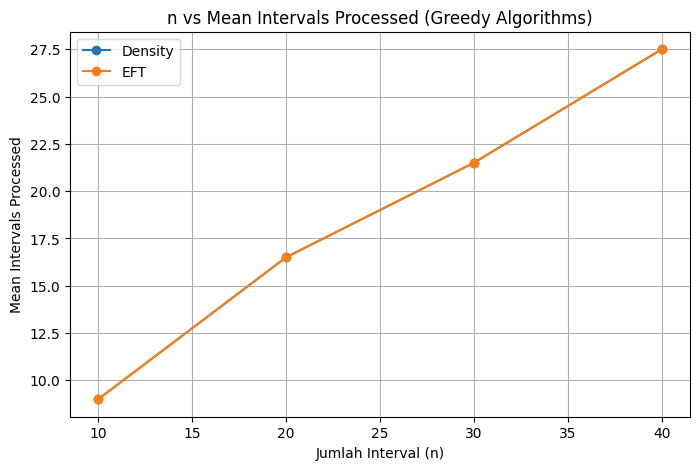

In [ ]:
import matplotlib.pyplot as plt                           # O(1)

# =========================================================
# LINE CHART: n vs Mean Intervals Processed per Algoritma
# =========================================================

plt.figure(figsize=(8, 5))                                # O(1)

for algo in mean_intervals_table['algorithm'].unique():  # O(A)
    subset = mean_intervals_table[                        # O(N)
        mean_intervals_table['algorithm'] == algo         # O(N)
    ]

    plt.plot(                                             # O(1)
        subset['n'],                                      # O(1)
        subset['mean_intervals_processed'],               # O(1)
        marker='o',
        label=algo
    )

plt.xlabel('Jumlah Interval (n)')                         # O(1)
plt.ylabel('Mean Intervals Processed')                    # O(1)
plt.title('n vs Mean Intervals Processed (Greedy Algorithms)')  # O(1)
plt.legend()                                              # O(A)
plt.grid(True)                                            # O(1)

plt.show()                                                # O(1)

In [ ]:
import pandas as pd                                      # O(1)

# 1. Pisahkan data (Gunakan results_df yang sudah ada)
eft_df = results_df[results_df["algorithm"] == "EFT"]   # O(N)
den_df = results_df[results_df["algorithm"] == "Density"]  # O(N)

# 2. Gabungkan (Merge)
paired_df = pd.merge(                                   # O(N log N) ~ O(N)
    eft_df,
    den_df,
    on=["n", "seed"],                                   # Key merge
    suffixes=("_EFT", "_Density")
)

# 3. Tampilkan Hasil
paired_df[                                              # O(N)
    ["n", "seed", "runtime_ms_EFT", "runtime_ms_Density"]
].head()                                                # O(1)

,n,seed,runtime_ms_EFT,runtime_ms_Density
0,10,0,2.3581,2.5748
1,10,1,2.2563,3.7243
2,20,0,3.3629,3.2065
3,20,1,3.0277,3.9660
4,30,0,3.2506,3.6000


In [ ]:
from scipy.stats import ttest_rel                 # O(1)

t_stat, p_value = ttest_rel(                      # O(N)
    paired_df["runtime_ms_EFT"],                  # O(N)
    paired_df["runtime_ms_Density"]               # O(N)
)

print("=== PAIRED T-TEST (Runtime) ===")           # O(1)
print(f"t-statistic : {t_stat:.4f}")               # O(1)
print(f"p-value     : {p_value:.6f}")              # O(1)

=== PAIRED T-TEST (Runtime) ===
t-statistic : -1.2672
p-value     : 0.245604


## BEST DAN WORST CASE

In [ ]:
# =========================================================
# SIMULASI PENCARIAN BEST CASE & WORST CASE
# =========================================================
print("Mencari kasus di mana Density mengalahkan EFT...")     # O(1)

best_case_found = None                                      # O(1)
max_gap = -1                                                # O(1)
num_trials = 2000                                           # O(1)
sample_size = 20                                            # O(1)

np.random.seed(42)                                          # O(1)

for i in range(num_trials):                                 # O(T)
    subset = df.sample(                                     # O(n)
        n=sample_size, random_state=i
    ).reset_index(drop=True)                                # O(n)
    
    sched_eft, _ = run_algo_eft(subset)                     # O(n log n)
    sched_den, _ = run_algo_density(subset)                 # O(n log n + n²)
    
    score_eft = sum(row['SKS'] for row in sched_eft)        # O(n)
    score_den = sum(row['SKS'] for row in sched_den)        # O(n)
    
    if score_den > score_eft:                               # O(1)
        gap = score_den - score_eft                         # O(1)
        if gap > max_gap:                                   # O(1)
            max_gap = gap                                   # O(1)
            best_case_found = {                             
                'seed': i,
                'score_eft': score_eft,
                'score_den': score_den,
                'gap': gap,
                'sched_den': pd.DataFrame(sched_den),       # O(n)
                'sched_eft': pd.DataFrame(sched_eft)        # O(n)
            }

if best_case_found:                                         # O(1)
    print(f"\n[DITEMUKAN!] Best Case Profit Density (Worst Case EFT)")  # O(1)
    print(f"Pada Seed Random: {best_case_found['seed']}")   # O(1)
    print(f"Total SKS Density : {best_case_found['score_den']} (MENANG)") # O(1)
    print(f"Total SKS EFT     : {best_case_found['score_eft']} (KALAH)")  # O(1)
    print(f"Selisih (Gap)     : {best_case_found['gap']} SKS")            # O(1)
    
    print("\n--- Jadwal Pilihan Density (SKS Besar/Padat) ---") # O(1)
    print(
        best_case_found['sched_den']
        [['Mata Kuliah', 'start', 'finish', 'SKS', 'profit_density']]
        .to_string(index=False)                             # O(n)
    )
    
    print("\n--- Jadwal Pilihan EFT (Cepat Selesai) ---")     # O(1)
    print(
        best_case_found['sched_eft']
        [['Mata Kuliah', 'start', 'finish', 'SKS', 'profit_density']]
        .to_string(index=False)                             # O(n)
    )
else:
    print("Belum ditemukan gap yang signifikan, naikkan num_trials.") # O(1)


Mencari kasus di mana Density mengalahkan EFT...

[DITEMUKAN!] Best Case Profit Density (Worst Case EFT)
Pada Seed Random: 1914
Total SKS Density : 39 (MENANG)
Total SKS EFT     : 34 (KALAH)
Selisih (Gap)     : 5 SKS

--- Jadwal Pilihan Density (SKS Besar/Padat) ---
                                     Mata Kuliah    start   finish  SKS  profit_density
                              Konsep Pemrograman 13:55:00 14:45:00    4            0.08
                                      Teori Game 10:15:00 11:05:00    3            0.06
                                    Semantic Web 07:30:00 08:20:00    3            0.06
                                    Semantic Web 09:20:00 10:10:00    3            0.06
                              Pembelajaran Mesin 10:15:00 11:05:00    3            0.06
                                Intelijen Bisnis 16:25:00 17:15:00    3            0.06
                                  Komputasi Grid 08:25:00 09:15:00    3            0.06
                            S

In [ ]:
import pandas as pd                                   # O(1)

print("--- PEMBUKTIAN BEST CASE: EFT (EARLIEST FINISH TIME) ---\n")  # O(1)

# =========================================================
# 1. BUAT DATA SKENARIO KHUSUS
# =========================================================

data_synth = pd.DataFrame({                            # O(n)
    'Hari': ['Senin', 'Senin', 'Senin'],
    'Mata Kuliah': [
        'Matkul A (Pagi)',
        'Matkul B (Siang - Jebakan Density)',
        'Matkul C (Sore)'
    ],
    'start':  ['08:00:00', '08:25:00', '09:00:00'],
    'finish': ['08:50:00', '09:15:00', '09:50:00'],
    'SKS': [3, 4, 3],
    'duration': [50, 50, 50],
    'profit_density': [0.06, 0.08, 0.06]
})

# =========================================================
# 2. PERSIAPAN DATA
# =========================================================

def get_minutes_simple(t_str):                         # O(1)
    h, m, s = map(int, str(t_str).split(':'))          # O(1)
    return h * 60 + m                                  # O(1)

data_synth['start_abs'] = data_synth['start'].apply(  # O(n)
    get_minutes_simple
)
data_synth['finish_abs'] = data_synth['finish'].apply(# O(n)
    get_minutes_simple
)
data_synth['id'] = data_synth.index                   # O(n)

# =========================================================
# 3. PANGGIL ALGORITMA
# =========================================================

raw_eft = run_algo_eft(data_synth)                    # O(n log n)
raw_den = run_algo_density(data_synth)                # O(n log n + n²)

sched_eft = raw_eft[0] if isinstance(raw_eft, tuple) else raw_eft  # O(1)
sched_den = raw_den[0] if isinstance(raw_den, tuple) else raw_den  # O(1)

# =========================================================
# 4. HITUNG HASIL
# =========================================================

sks_eft = sum(row['SKS'] for row in sched_eft)         # O(n)
sks_den = sum(row['SKS'] for row in sched_den)         # O(n)

print(f"Total SKS EFT     : {sks_eft} (MENANG)")       # O(1)
print(f"Total SKS Density : {sks_den} (KALAH)")        # O(1)
print(f"Selisih (Gap)     : {sks_eft - sks_den} SKS")  # O(1)

print("\n[Jadwal Pilihan EFT - Cepat Selesai & Dapat Banyak]")  # O(1)
print(
    pd.DataFrame(sched_eft)
    [['Mata Kuliah', 'start', 'finish', 'SKS', 'profit_density']]
    .to_string(index=False)                            # O(n)
)

print("\n[Jadwal Pilihan Density - Terkecoh Matkul 'Mahal']")   # O(1)
print(
    pd.DataFrame(sched_den)
    [['Mata Kuliah', 'start', 'finish', 'SKS', 'profit_density']]
    .to_string(index=False)                            # O(n)
)

--- PEMBUKTIAN BEST CASE: EFT (EARLIEST FINISH TIME) ---

Total SKS EFT     : 6 (MENANG)
Total SKS Density : 4 (KALAH)
Selisih (Gap)     : 2 SKS

[Jadwal Pilihan EFT - Cepat Selesai & Dapat Banyak]
    Mata Kuliah    start   finish  SKS  profit_density
Matkul A (Pagi) 08:00:00 08:50:00    3            0.06
Matkul C (Sore) 09:00:00 09:50:00    3            0.06

[Jadwal Pilihan Density - Terkecoh Matkul 'Mahal']
                       Mata Kuliah    start   finish  SKS  profit_density
Matkul B (Siang - Jebakan Density) 08:25:00 09:15:00    4            0.08
